In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from gala.coordinates import GD1Koposov10, reflex_correct
import matplotlib.pyplot as plt
import pandas as pd

from episode_functions import *

In [9]:
filename = 'gd1_data.hdf'
centerline_df = pd.read_hdf(filename, 'centerline_df')
selected_df = pd.read_hdf(filename, 'selected_df')

In [6]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max = 1.0

pm1_rect, pm2_rect = make_rectangle(pm1_min, pm1_max, pm2_min, pm2_max)
gd1_frame = GD1Koposov10()

# Transform and Select

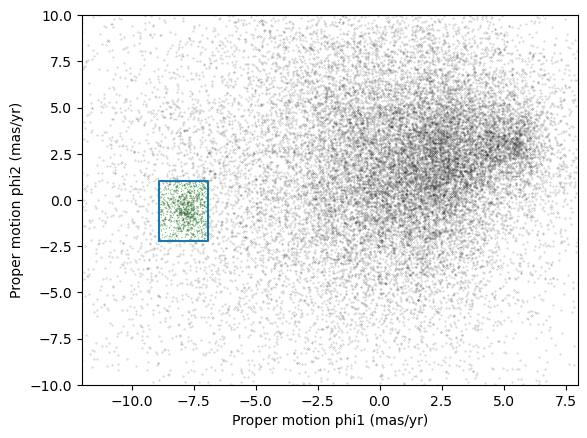

In [12]:
plot_proper_motion(centerline_df)
plt.plot(pm1_rect, pm2_rect)
x = selected_df['pm_phi1']
y = selected_df['pm_phi2']

plt.plot(x, y, 'gx', markersize=0.3, alpha=0.3)

(-20.0, 5.0)

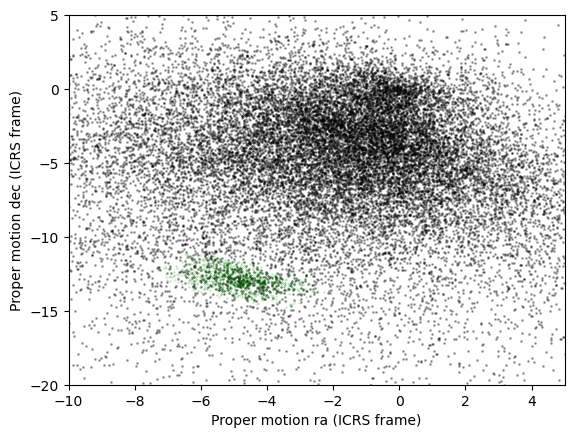

In [13]:
x = centerline_df['pmra']
y = centerline_df['pmdec']

plt.plot(x, y, 'ko', markersize=1, alpha=0.3)

x = selected_df['pmra']
y = selected_df['pmdec']
plt.plot(x, y, 'gx', markersize=1, alpha=0.2)

plt.xlabel('Proper motion ra (ICRS frame)')
plt.ylabel('Proper motion dec (ICRS frame)')

plt.xlim([-10, 5])
plt.ylim([-20, 5])

In [14]:
pmra_min = -6.7
pmra_max = -3
pmdec_min=-14.31
pmdec_max = -11.2

## Assembling the query

In [15]:
candidate_coord_query_base = """
SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax<1
AND bp_rp BETWEEN -0.75 AND 2
AND 1 = CONTAINS(POINT(ra, dec),
                POLYGON({sky_point_list}))
"""

In [17]:
phi1_min = -70 *u.degree
phi1_max = -20 * u.degree
phi2_min = -5 * u.degree
phi2_max = 5 * u.degree

In [18]:
phi1_rect, phi2_rect = make_rectangle(phi1_min, phi1_max, phi2_min, phi2_max)

In [19]:
corners = SkyCoord(phi1=phi1_rect, phi2=phi2_rect, frame=gd1_frame)

In [20]:
corners_icrs = corners.transform_to('icrs')

In [21]:
sky_point_list = skycoord_to_string(corners_icrs)
sky_point_list

'135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862'

In [22]:
columns = 'source_id, ra, dec, pmra, pmdec'

In [25]:
candidate_coord_query = candidate_coord_query_base.format(columns=columns, sky_point_list=sky_point_list)
print(candidate_coord_query)


SELECT
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax<1
AND bp_rp BETWEEN -0.75 AND 2
AND 1 = CONTAINS(POINT(ra, dec),
                POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))



## Selecting proper motion

In [26]:
candidate_coord_query_base = """
SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax<1
AND bp_rp BETWEEN -0.75 AND 2
AND 1 = CONTAINS(POINT(ra, dec),
                POLYGON({sky_point_list}))
AND pmra BETWEEN {pmra_min} AND {pmra_max}
AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""

In [28]:
candidate_coord_pm_query = candidate_coord_query_base.format(columns=columns, sky_point_list=sky_point_list, 
                                                             pmra_min=pmra_min, pmra_max=pmra_max, pmdec_min=pmdec_min,
                                                             pmdec_max=pmdec_max)

In [29]:
candidate_coord_pm_job = Gaia.launch_job_async(candidate_coord_pm_query)
print(candidate_coord_pm_job)

INFO: Query finished. [astroquery.utils.tap.core]
<Table length=8409>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
source_id   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
Jobid: 1704601575951O
Phase: COMPLETED
Owner: None
Output file: async_20240106222615.vot
Results: None


In [30]:
candidate_gaia_table = candidate_coord_pm_job.get_results()
len(candidate_gaia_table)

8409

In [31]:
d = dict(sky_point_list=sky_point_list, pmra_min=pmra_min, pmra_max=pmra_max, pmdec_min=pmdec_min, pmdec_max=pmdec_max)

In [32]:
d

{'sky_point_list': '135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862',
 'pmra_min': -6.7,
 'pmra_max': -3,
 'pmdec_min': -14.31,
 'pmdec_max': -11.2}

In [33]:
point_series = pd.Series(d)
point_series

sky_point_list    135.306, 8.39862, 126.51, 13.4449, 163.017, 54...
pmra_min                                                       -6.7
pmra_max                                                         -3
pmdec_min                                                    -14.31
pmdec_max                                                     -11.2
dtype: object

In [34]:
filename='gd1_data.hdf'
point_series.to_hdf(filename, 'point_series')

/var/folders/6l/54htg8p52b762n_6mhsb13v80000gn/T/ipykernel_17200/2611916173.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  point_series.to_hdf(filename, 'point_series')


## Plotting one more time

Text(0, 0.5, 'dec (degree ICRS)')

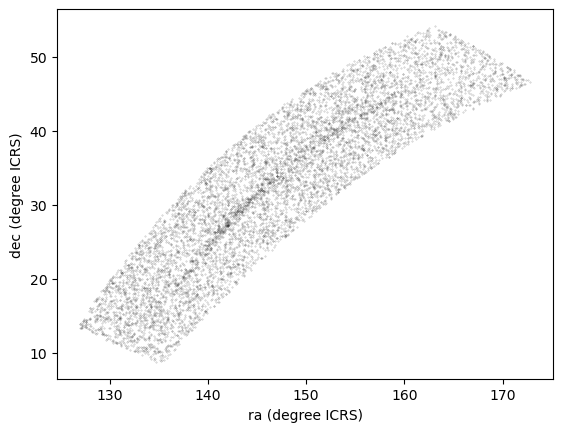

In [35]:
x = candidate_gaia_table['ra']
y = candidate_gaia_table['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)')

In [36]:
candidate_gaia_df = make_dataframe(candidate_gaia_table)

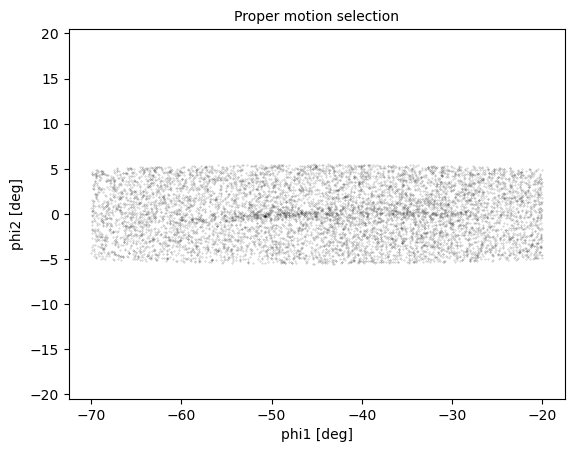

In [37]:
plot_pm_selection(candidate_gaia_df)

# Episode 6: JOIN

* Create plot in lower right panel of Fig 1
* CMD of GD1 based on PanSTARRS photometry
* Select stars around a theoretical isochrone

* Already use BP_RP to exclude M dwarfs
* Wide Gaia bands aren't well suited for CMD
* Use narrower PanSTARRs filters g and i
* Gaia has already done the hard part of matching stars based on location and properties like color and brightness

## The best neighbour table

* Cross-matching has been done - but we still need to connect the Gaia and the PanSTARRs tables
* join using a common "key" between tables (often id)
* Stars in the Gaia dataset are identified by `source_id`
* Stars in the PanSTARRs dataset are identified by `obj_id`
* For each candidate star we have `source_id`, we now need to find `obj_id`
* `panstarrs1_best_neighbour` table tells us how to map `source_id` to `original_ext_source_id` which is the panstarrs `obj_id`
* We will JOIN gaia_source with `panstarrs1_best_neighbour` to get the `original_ext_source_id` of all of our candidate stars
* We will use JOIN again and the `original_ext_source_id` of our candidate stars to get the panstarrs photometry from `panstarrs1_original_valid`

Note the british spelling of neighbour

Let's explore these tables before we do the JOIN

In [40]:
ps_best_neighbour_meta = Gaia.load_table('gaiadr2.panstarrs1_best_neighbour')

Retrieving table 'gaiadr2.panstarrs1_best_neighbour'


In [41]:
print(ps_best_neighbour_meta)

TAP Table name: gaiadr2.gaiadr2.panstarrs1_best_neighbour
Description: Pan-STARRS1 BestNeighbour table lists each matched Gaia object with its
best neighbour in the external catalogue.
There are 1 327 157 objects in the filtered version of Pan-STARRS1 used
to compute this cross-match that have too early epochMean.
Num. columns: 7


In [42]:
for column in ps_best_neighbour_meta.columns:
    print(column.name)

source_id
original_ext_source_id
angular_distance
number_of_neighbours
number_of_mates
best_neighbour_multiplicity
gaia_astrometric_params


* go through columns
* best_neighbour_multiplicity: how many PS stars matched with the same probability to this Gaia source - should be 1
* number_of_mates: number of other Gaia sources that matched to this PS source - should be 0
* original_ext_source_id = obj_id for PS
* number_of_neighbours: how many PS stars matched with the same probability to this Gaia source based just on location (we wont use this one)

In [45]:
ps_best_neighbour_query = """
SELECT
TOP 5
source_id, best_neighbour_multiplicity, number_of_mates, original_ext_source_id
FROM gaiadr2.panstarrs1_best_neighbour
"""

In [46]:
ps_best_neighbour_job = Gaia.launch_job_async(ps_best_neighbour_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [47]:
ps_best_neighbour_results = ps_best_neighbour_job.get_results()
ps_best_neighbour_results

source_id,best_neighbour_multiplicity,number_of_mates,original_ext_source_id
int64,int16,int16,int64
6745938972433480704,1,0,69742925668851205
6030466788955954048,1,0,69742509325691172
6756488099308169600,1,0,69742879438541228
6700154994715046016,1,0,69743055581721207
6757061941303252736,1,0,69742856540241198


## The PanSTARRS Table

In [48]:
ps_valid_meta = Gaia.load_table('gaiadr2.panstarrs1_original_valid')

Retrieving table 'gaiadr2.panstarrs1_original_valid'


In [49]:
print(ps_valid_meta)

TAP Table name: gaiadr2.gaiadr2.panstarrs1_original_valid
Description: The Panoramic Survey Telescope and Rapid Response System (Pan-STARRS) is
a system for wide-field astronomical imaging developed and operated by
the Institute for Astronomy at the University of Hawaii. Pan-STARRS1
(PS1) is the first part of Pan-STARRS to be completed and is the basis
for Data Release 1 (DR1). The PS1 survey used a 1.8 meter telescope and
its 1.4 Gigapixel camera to image the sky in five broadband filters (g,
r, i, z, y).

The current table contains a filtered subsample of the 10 723 304 629
entries listed in the original ObjectThin table.
We used only ObjectThin and MeanObject tables to extract
panstarrs1OriginalValid table, this means that objects detected only in
stack images are not included here. The main reason for us to avoid the
use of objects detected in stack images is that their astrometry is not
as good as the mean objects astrometry: “The stack positions (raStack,
decStack) have considera

In [51]:
for column in ps_valid_meta.columns:
    print(column.name)

obj_name
obj_id
ra
dec
ra_error
dec_error
epoch_mean
g_mean_psf_mag
g_mean_psf_mag_error
g_flags
r_mean_psf_mag
r_mean_psf_mag_error
r_flags
i_mean_psf_mag
i_mean_psf_mag_error
i_flags
z_mean_psf_mag
z_mean_psf_mag_error
z_flags
y_mean_psf_mag
y_mean_psf_mag_error
y_flags
n_detections
zone_id
obj_info_flag
quality_flag


* We will use: `obj_id`, `g_mean_psf_mag`, and `i_mean_psf_mag`

In [52]:
ps_valid_query = """
SELECT
TOP 5
obj_id, g_mean_psf_mag, i_mean_psf_mag
FROM gaiadr2.panstarrs1_original_valid
"""

In [53]:
ps_valid_job = Gaia.launch_job_async(ps_valid_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [54]:
ps_valid_results = ps_valid_job.get_results()
ps_valid_results

obj_id,g_mean_psf_mag,i_mean_psf_mag
,,mag
int64,float64,float64
67130655389101425,--,20.3516006469727
67553305590067819,--,19.779899597168
67551423248967849,--,19.8889007568359
67132026238911331,--,20.9062995910645
67553513677687787,--,21.2831001281738


## Joining tables

* talk through figures
* not necessarily in the same order --> requires ADQL to search (its optimized for this)

* This a complex query --> start with a simplified cone search and then expand from there when we have the JOINS right

In [55]:
test_cone_query = """
SELECT 
TOP 10
source_id
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
    POINT(ra, dec),
    CIRCLE(88.8, 7.4, 0.083333))
"""

In [56]:
test_cone_job = Gaia.launch_job(test_cone_query)

In [57]:
test_cone_results = test_cone_job.get_results()
test_cone_results

source_id
int64
3322773965056065536
3322773758899157120
3322774068134271104
3322773930696320512
3322774377374425728
3322773724537891456
3322773724537891328
3322773930696321792
3322773724537890944


Start adding features:
* make columns selected variable

In [58]:
cone_base_query = """
SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
    POINT(ra, dec),
    CIRCLE(88.8, 7.4, 0.083333))
"""

In [59]:
columns='source_id, ra, dec, pmra, pmdec'
cone_query = cone_base_query.format(columns=columns)

In [60]:
print(cone_query)


SELECT 
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
    POINT(ra, dec),
    CIRCLE(88.8, 7.4, 0.083333))



In [61]:
cone_job = Gaia.launch_job_async(cone_query)
cone_results = cone_job.get_results()
cone_results

INFO: Query finished. [astroquery.utils.tap.core]


source_id,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907
3322773758899157120,88.83227057144585,7.325577341429926,--,--
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086
...,...,...,...,...
3322962939322692608,88.73289357818679,7.407688975612043,-0.11002934783569704,1.002126813991455


## Adding the best neighbour table

* JOIN: which table we want to connect to
* ON: which keys match from each table
* AS: alias so I don't have to type the whole table name every time

In [62]:
neighbours_base_query = """
SELECT
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
    ON gaia.source_id = best.source_id
WHERE 1 = CONTAINS(
    POINT(gaia.ra, gaia.dec),
    CIRCLE(88.8, 7.4, 0.0833333))
"""

side note: because the key in both tables is `source_id` we could use `USING(source_id)` instead of ON

* We have to use qualified column names: more than one table
* Keys in each table do not have to be the same name

In [63]:
# Make a new column list - you can see why we use aliases for table names
column_list_neighbours = [
    'gaia.source_id',
    'gaia.ra', 
    'gaia.dec',
    'gaia.pmra', 
    'gaia.pmdec', 
    'best.best_neighbour_multiplicity',
    'best.number_of_mates']

In [64]:
columns = ', '.join(column_list_neighbours)
neighbours_query = neighbours_base_query.format(columns=columns)
print(neighbours_query)


SELECT
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
    ON gaia.source_id = best.source_id
WHERE 1 = CONTAINS(
    POINT(gaia.ra, gaia.dec),
    CIRCLE(88.8, 7.4, 0.0833333))



In [65]:
neighbours_job = Gaia.launch_job_async(neighbours_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [66]:
neighbours_results = neighbours_job.get_results()
neighbours_results

source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates
,deg,deg,mas / yr,mas / yr,,
int64,float64,float64,float64,float64,int16,int16
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907,1,0
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044,1,0
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717,1,0
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435,1,0
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086,1,0
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576,1,0
...,...,...,...,...,...,...
3322963527732585984,88.78813701704823,7.456696889759524,1.1363354614104264,-2.46251296961979,1,0


* this has fewer rows than before we made the join because not all Gaia stars are in the Pan-STARRS table

Exercise: 
Now we are ready to bring in the Pan-STARRS table. Starting with the previous query, add a second JOIN clause that joins with `gaiadr2.panstarrs1_original_valid`, gives it the abbreviated name `ps`, and matches `original_ext_source_id` from the best neighbor table with `obj_id` from the Pan-STARRS table.

Add `g_mean_psf_mag` and `i_mean_psf_mag` to the column list and run the query. The result shoud contain 490 rows and 9 columns

In [91]:
join_solution_query_base = """
SELECT
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
    ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid AS ps
    ON best.original_ext_source_id = ps.obj_id
WHERE 1 = CONTAINS(
    POINT(gaia.ra, gaia.dec),
    CIRCLE(88.8, 7.4, 0.0833333))
"""
column_list_ps = [
    'gaia.source_id',
    'gaia.ra', 
    'gaia.dec',
    'gaia.pmra', 
    'gaia.pmdec', 
    'best.best_neighbour_multiplicity',
    'best.number_of_mates', 
    'ps.g_mean_psf_mag',
    'ps.i_mean_psf_mag']

column_list = columns=', '.join(column_list_ps)
join_solution_query = join_solution_query_base.format(columns=column_list)

join_solution_job = Gaia.launch_job(join_solution_query)
join_solution_results = join_solution_job.get_results()
join_solution_results

source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
,deg,deg,mas / yr,mas / yr,,,,mag
int64,float64,float64,float64,float64,int16,int16,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907,1,0,19.9431991577148,17.4221992492676
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044,1,0,18.6212005615234,16.6007995605469
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717,1,0,--,20.2203998565674
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435,1,0,18.0676002502441,16.9762001037598
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086,1,0,20.1907005310059,17.8700008392334
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576,1,0,22.6308002471924,19.6004009246826
...,...,...,...,...,...,...,...,...
3322963527732585984,88.78813701704823,7.456696889759524,1.1363354614104264,-2.46251296961979,1,0,17.8034992218018,16.1214008331299


## Selecting by Coordinates and proper motion

* Switch from cone search to our previous filters on both location and proper motion

In [85]:
#from previous episode
candidate_coord_pm_query_base = """
SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec),
                     POLYGON({sky_point_list}))
    AND pmra BETWEEN {pmra_min} AND {pmra_max}
    AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""

In [86]:
columns = 'source_id, ra, dec, pmra, pmdec'
candidate_coord_pm_query = candidate_coord_pm_query_base.format(columns=columns, 
                                                                sky_point_list=sky_point_list,
                                                               pmra_min=pmra_min,
                                                               pmra_max=pmra_max,
                                                               pmdec_min=pmdec_min,
                                                               pmdec_max=pmdec_max)
print(candidate_coord_pm_query)


SELECT
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec),
                     POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
    AND pmra BETWEEN -6.7 AND -3
    AND pmdec BETWEEN -14.31 AND -11.2



Make sure it works

In [88]:
candidate_coord_pm_job = Gaia.launch_job_async(candidate_coord_pm_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [89]:
candidate_coord_pm_results = candidate_coord_pm_job.get_results()
candidate_coord_pm_results

source_id,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
635559124339440000,137.58671691646745,19.1965441084838,-3.770521900009566,-12.490481778113859
635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392
635674126383965568,138.8428741026386,19.031798198627634,-3.8970011609340207,-12.702779525389634
635614168640132864,139.59219748145836,18.807955539071433,-3.309602916796381,-13.708904908478631
635523531945742592,137.1439946395468,18.845588306639165,-3.9036930274876585,-11.634380634589444
635821843194387840,139.88094034815086,19.62185456718988,-6.544201177153814,-12.55978220563274
...,...,...,...,...
612296172717818624,133.80060286960668,18.08186533343457,-6.112792578821885,-12.50750861370402


Exercise:
Create a new query base called `candidate_join_query_base` that combines the WHERE clauses from `candidate_coord_pm_query_base` with the JOIN clauses from `join_solution_query_base` for the best neighbours table and the photometry table (original valid). Format the query base using the column names in `column_list` and call the result `candidate_join_query`.

Hint: Make sure you use qualified column names everywhere!

Run your query and download teh results. The table you get should have 4300 rows and 9 columns

In [93]:
candidate_join_query_base = """
SELECT
{column_list}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
    ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid AS ps
    ON best.original_ext_source_id = ps.obj_id
WHERE gaia.parallax < 1
    AND gaia.bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(gaia.ra, gaia.dec),
                     POLYGON({sky_point_list}))
    AND gaia.pmra BETWEEN {pmra_min} AND {pmra_max}
    AND gaia.pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""

In [94]:
candidate_join_query = candidate_join_query_base.format(column_list=column_list, sky_point_list=sky_point_list,
                                                        pmra_min=pmra_min, pmra_max=pmra_max, pmdec_min=pmdec_min, 
                                                        pmdec_max=pmdec_max)

In [95]:
candidate_join_job = Gaia.launch_job_async(candidate_join_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [98]:
candidate_table = candidate_join_job.get_results()

## Checking the match

how is the match between our Gaia and PanSTARRS tables?

In [99]:
candidate_table['best_neighbour_multiplicity']

1
1
1
1
1
1
1
1
1
...
1


it looks like they are all one - but lets check 

In [100]:
multiplicity = pd.Series(candidate_table['best_neighbour_multiplicity'])
multiplicity.describe()

/Users/bostroem/opt/anaconda3/envs/AstronomicalData/lib/python3.12/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


count    4300.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

they are all 1 --> every candidate star has a single best match

Note numpy warning

In [101]:
mates = pd.Series(candidate_table['number_of_mates'])
mates.describe()

/Users/bostroem/opt/anaconda3/envs/AstronomicalData/lib/python3.12/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


count    4300.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

all 0 (only one Gaia match for each PanSTARRS source)

## Saving the DataFrame

This is our final query - we should save it

In [102]:
candidate_df = make_dataframe(candidate_table)

In [103]:
filename='gd1_data.hdf'
candidate_df.to_hdf(filename, 'candidate_df')

In [104]:
from os.path import getsize
MB = 1024*1024
getsize(filename)/MB

15.422508239746094

## Another file format - CSV

* Lots of output formats in Pandas
* CSV = comma separated values
* Plain text, easy to ready, lowest common denominator of data formats
* limitations
    - data types lost (true of data frames too)
    - can end up with extra columns
    - can't have a comma in any column (e.g. g,r,i)
    - big and slow to read and write

In [105]:
candidate_df.to_csv('gd1_data.csv')

In [106]:
getsize('gd1_data.csv')/MB

0.8787498474121094

In [108]:
read_back_csv = pd.read_csv('gd1_data.csv')

In [109]:
candidate_df.head(3)

,source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag,phi1,phi2,pm_phi1,pm_phi2
0,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,1,0,17.8978,17.517401,-59.247330,-2.016078,-7.527126,1.748779
1,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,1,0,19.2873,17.678101,-59.133391,-2.306901,-7.560608,-0.741800
2,635614168640132864,139.592197,18.807956,-3.309603,-13.708905,1,0,16.1516,14.666300,-58.938113,-3.024192,-8.062762,-1.869082


In [110]:
read_back_csv.head(3)

,Unnamed: 0,source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag,phi1,phi2,pm_phi1,pm_phi2
0,0,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,1,0,17.8978,17.517401,-59.247330,-2.016078,-7.527126,1.748779
1,1,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,1,0,19.2873,17.678101,-59.133391,-2.306901,-7.560608,-0.741800
2,2,635614168640132864,139.592197,18.807956,-3.309603,-13.708905,1,0,16.1516,14.666300,-58.938113,-3.024192,-8.062762,-1.869082


* got an extra column

## Key Points
* Use JOIN to combine multiple tables with some identified key to match records
* save to fits or HDF5 rather that CSV. binary, store metadata, don't lose anything when write and read back
* CSV is least common denominator

# Episode 7: Photometry

In [112]:
import numpy as np

In [114]:
g_all = iso_df['mag_g']
g_mask = (g_all > 18.0) & (g_all < 21.5)
g_mask.sum()

117

In [115]:
iso_masked = iso_df[g_mask]
g = iso_masked['mag_g']
left_color = iso_masked['color_g_i']-0.06
right_color = iso_masked['color_g_i']+0.12

In [116]:
reverse_right_color= right_color[::-1]

In [117]:
color_loop = np.append(left_color, reverse_right_color)

In [118]:
mag_loop = np.append(g, g[::-1])

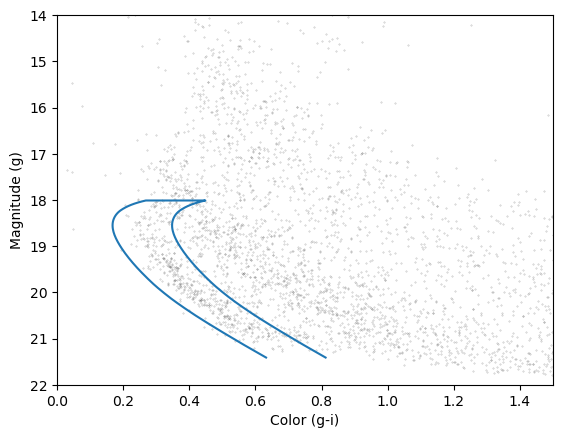

In [119]:
plot_cmd(candidate_df)
plt.plot(color_loop, mag_loop)

In [120]:
loop_df = pd.DataFrame()
loop_df['color_loop'] = color_loop
loop_df['mag_loop'] = mag_loop

In [121]:
from matplotlib.patches import Polygon

In [122]:
polygon = Polygon(loop_df)

In [123]:
loop_df.to_hdf('gd1_data.hdf', 'loop_df')

In [113]:
iso_df = pd.read_hdf('gd1_isochrone.hdf5', 'iso_df')

In [111]:
cmd_df = pd.DataFrame()
cmd_df['color'] = candidate_df['g_mean_psf_mag'] - candidate_df['i_mean_psf_mag']
cmd_df['mag'] = candidate_df['g_mean_psf_mag']

In [125]:
inside_mask = polygon.contains_points(cmd_df)

In [126]:
winner_df = candidate_df[inside_mask]

In [127]:
filename

'gd1_data.hdf'

In [128]:
winner_df.to_hdf(filename, 'winner_df')

# Episode 8: Visualization

## Making Figures that Tell a Story

* Figures so far have been rough and ready
* How can we make our figures publication ready?
* How can we make figures that communicate a scientific result clearly and compellingly?

Think about the following questions:
1. What is the primary scientific result of this work?
2. What story is this figure telling?
3. In the design of this figure, can you identify 1 or 2 choices that the authors made that you think are effective? Think about big-picture elements, like the number of panels and how they are arranged as well as details like the choice of typeface.
4. Can you identify 1 or 2 elements that could be improved or that you might have done differently?

3. black and white - minimal use of color, mostly large fonts - minimal adjustment to be accessible to low vision readers and none to accommodate those with poor color vision. Annotations in te bottom left panel guide the reader to the results discussed in the text. Panels with the same units are lined up
4. on-sky positions likely do not need so much white space, aces ticks for the on-sky position figure are not necessary, text annotations could be darker with whiter background, legend in bottom right panels should be bigger

## Plotting GD-1 with Annotations

Successful annotations in the lower left panel
1. vertical dashed line to distinguish previously undetected region of GD-1
2. label that identifies the new region
3. several other text and arrows to identify features in GD-1

Exercise: Plot the selected stars in winner_df using the plot_cmd_selection function and then choose any or all of these features and add them to the figure:
* to draw the verical lines see plt.vlines and plt.axvline
* to add text see plt.text
* to add an annotation with text and an arrow see plt.annontate

Text(-25, 5.5, 'Gap')

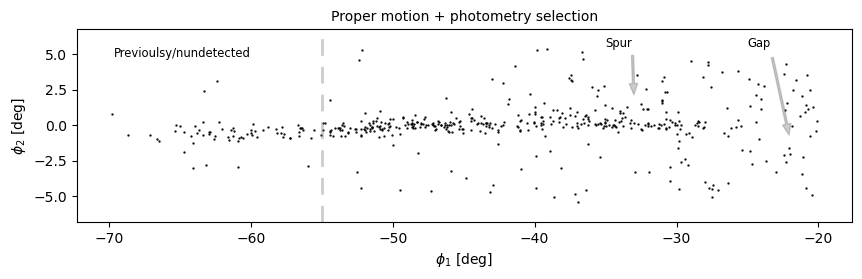

In [134]:
fig = plt.figure(figsize=(10, 2.5))
plot_cmd_selection(winner_df)
plt.axvline(-55, ls='--', color='gray', 
            alpha=0.4, dashes=(6,4), lw=2)
plt.text(-60, 5.5, 'Previoulsy/nundetected', fontsize='small', ha='right', va='top')

arrowprops = dict(color='gray', shrink=0.05, width=1.5, 
                  headwidth=6, headlength=8, alpha=0.4)
plt.annotate('Spur', xy=(-33, 2), xytext=(-35, 5.5), 
             arrowprops=arrowprops, fontsize='small')

plt.annotate('Gap', xy=(-22, -1), xytext=(-25, 5.5),
             arrowprops=arrowprops, fontsize='small')

## Customization

Ways to override default styles:
* current figure: individual functions
* all figures in a notebook: rcParams
* more than a few: style files

Note on accessibility:
* think about accessibility for individuals with low vision and color-blindness. AAS Journals has a Graphics Guide

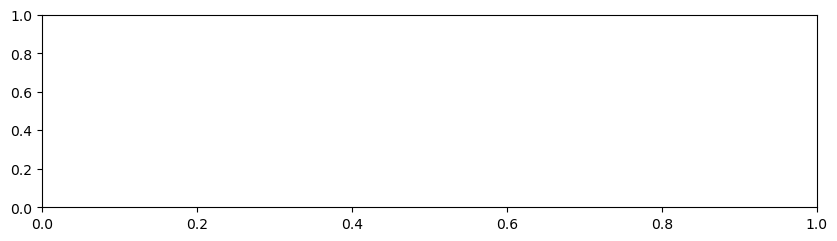

In [136]:
# figure and axis object
fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(1,1,1) 


* matplotlib uses axes and subplot interchangably. Subplot is an axes object with additional methods and attributes
* specify num col and num row
* plot num: starts upper left and goes across and then down

#### Changing the current figure: individual functions

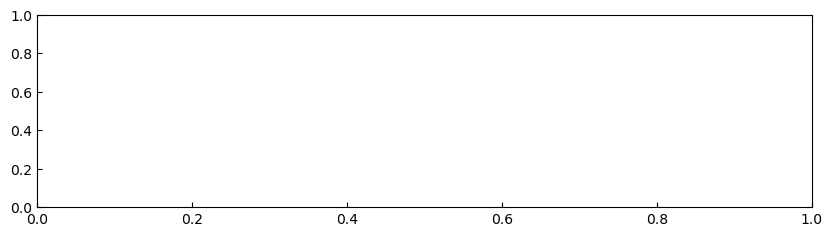

In [138]:
#change ticks to point inside figure
fig = plt.figure(figsize=(10,2.5))
ax = fig.add_subplot(1,1,1)
ax.tick_params(direction='in')

Exercise: Read the documentation of tick_params and use it to put ticks on the top and right sides of the axes

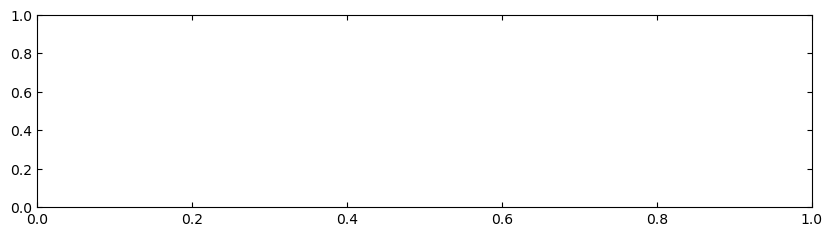

In [140]:
fig = plt.figure(figsize=(10,2.5))
ax = fig.add_subplot(1,1,1)
ax.tick_params(direction='in', right=True, top=True)

#### Modifying plots for a whole notebook: rcParams

* rcParams is a dictionary
* applies to everything in the notebook

In [142]:
# view rcParams values
plt.rcParams['font.size']

10.0

In [143]:
# set fontsize to new value
plt.rcParams['font.size']=14

Exercise: Plot the previous figure again and see what font sizess have changed. Look up another other elements of rcParams and change its value and check the effect on the figure

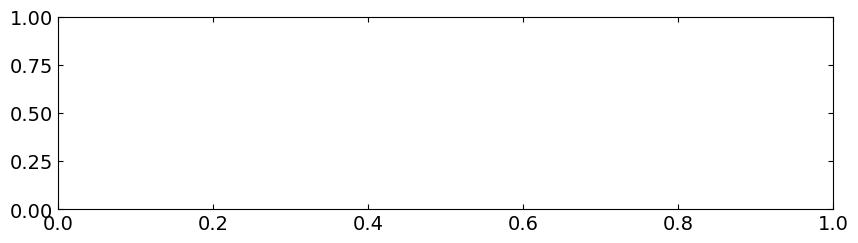

In [144]:
fig = plt.figure(figsize=(10,2.5))
ax = fig.add_subplot(1,1,1)
ax.tick_params(direction='in', right=True, top=True)

axis tick labels are bigger

* Default matplotlib settings from matplotlibrc
* Permanently change in matplotlibrc file
* to find:

In [145]:
import matplotlib as mpl
mpl.matplotlib_fname()

'/Users/bostroem/.matplotlib/matplotlibrc'

if that file doesn't exist - you can download a sample file and put is in your <home>/.matplotlib directory

## Style Sheets:

In [ ]:
style sheets allow you to have multiple sets of defaults for different situations (e.g. paper vs talk vs poster)

In [146]:
#view predefined styles
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'az-paper-onecol',
 'az-paper-twocol',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

note: seaborn-paper, seaborn-talk, seaborn-poster are already there for defaults

In [148]:
#Use a style:
plt.style.use('fivethirtyeight')

In [149]:
# Return to default
plt.style.use('default')

Exercise: Choose one of the styles on the list and select it by calling `use`. Then go back and plot one of the previous figures to see what changes in the figures appearance

In [150]:
plt.style.use('fivethirtyeight')

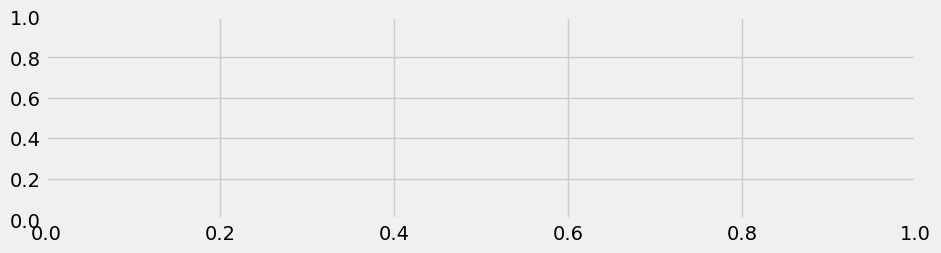

In [151]:
fig = plt.figure(figsize=(10,2.5))
ax = fig.add_subplot(1,1,1)
ax.tick_params(direction='in', right=True, top=True)

#### Custom style files

* az-paper-twocol: my twocolumn figure paper style

In [155]:
plt.style.use('default')
plt.style.use('./az-paper-twocol.mplstyle')

* ./ tells matplotlib to look in this directory
* default directory is stylelib directory in your default configuration directory

In [157]:
# Find default configuration directory
mpl.get_configdir()

'/Users/bostroem/.matplotlib'

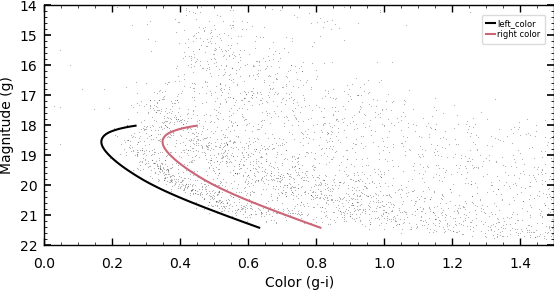

In [156]:
plot_cmd(candidate_df)
plt.plot(left_color, g, label='left_color')
plt.plot(right_color, g, label='right color')
plt.legend();

## Multiple Panels

* add_subplot: for same size panels
* subplot2grid for different size panels
* reuse our plotting functions

* subplot2grid: specify numcol, numrow as a tuple called shape and location of the subplot with x, y location
* e.g. 2 rows and 2 columns (2,2), first panel at (0,0)

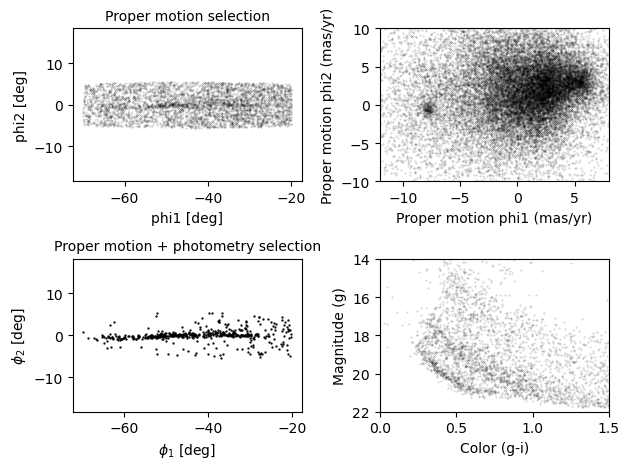

In [158]:
plt.style.use('default')

fig = plt.figure()
shape=(2,2)
ax1 = plt.subplot2grid(shape, (0,0))
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0,1))
plot_proper_motion(centerline_df)

ax3 = plt.subplot2grid(shape, (1,0))
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1,1))
plot_cmd(candidate_df)

plt.tight_layout()

* Tight_layout adjusts panel sizes to make sure axis labels don't overlap

Exercise: what happens if you leave out `tight_layout`?

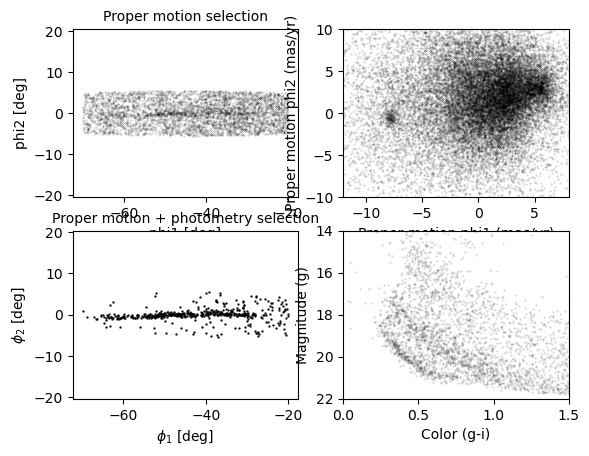

In [160]:
plt.style.use('default')

fig = plt.figure()
shape=(2,2)
ax1 = plt.subplot2grid(shape, (0,0))
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0,1))
plot_proper_motion(centerline_df)

ax3 = plt.subplot2grid(shape, (1,0))
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1,1))
plot_cmd(candidate_df)

## Adjusting Proportions

* use colspan to have a figure span multiple columns
* adjust shape to have more columns

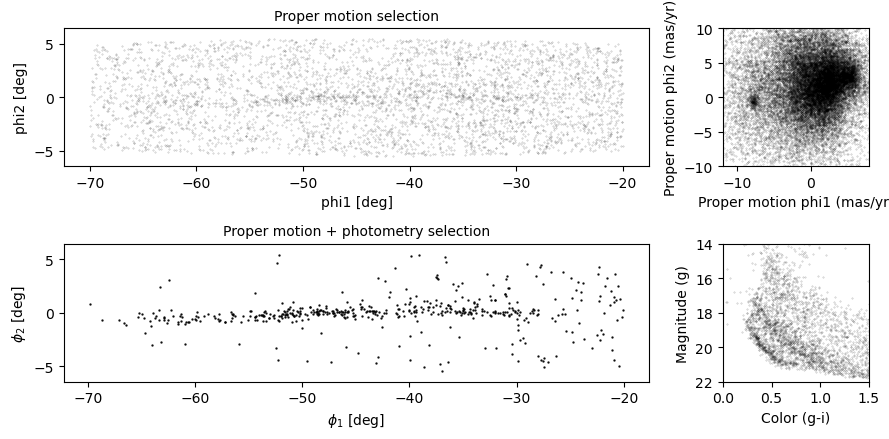

In [163]:
plt.style.use('default')

fig = plt.figure(figsize=(9, 4.5))
shape=(2,4) #Update this
ax1 = plt.subplot2grid(shape, (0,0), colspan=3) #update this
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0,3)) #update this
plot_proper_motion(centerline_df)

ax3 = plt.subplot2grid(shape, (1,0), colspan=3) #update this
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1,3)) #update this
plot_cmd(candidate_df)

plt.tight_layout();

Exercise: In this example, the ratio of the widths of the panels is 3:1. how would you adjust it if you wanted the ratio to be 3:2?

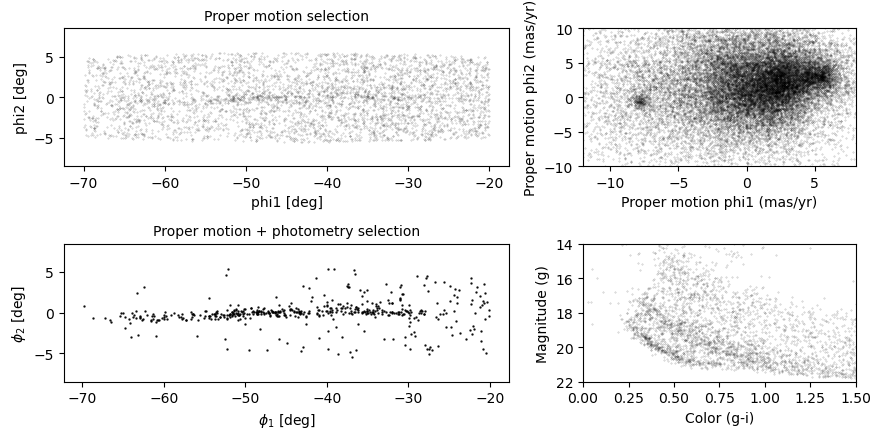

In [164]:
plt.style.use('default')

fig = plt.figure(figsize=(9, 4.5))
shape=(2,5) #Update this
ax1 = plt.subplot2grid(shape, (0,0), colspan=3) 
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0,3), colspan=2) #update this
plot_proper_motion(centerline_df)

ax3 = plt.subplot2grid(shape, (1,0), colspan=3) 
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1,3), colspan=2) #update this
plot_cmd(candidate_df)

plt.tight_layout();

## Adding the shaded regions

* missing the shaded region in proper motion plot
* in episode 4 we defined pm1_rect, pm2_rect
* use matplotlib Polygon function from episode 7
* need coordinates in an array of x values in first column and y values in second column 

In [165]:
vertices = np.transpose([pm1_rect, pm2_rect])
vertices

array([[-8.9, -2.2],
       [-8.9,  1. ],
       [-6.9,  1. ],
       [-6.9, -2.2],
       [-8.9, -2.2]])

In [167]:
# create polygon
poly = Polygon(vertices, closed=True, facecolor='orange', alpha=0.4)

(-10.0, 10.0)

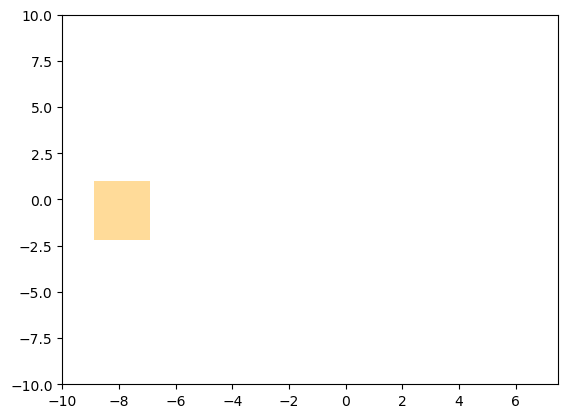

In [169]:
# use add_patch to put it on the plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.add_patch(poly)
ax.set_xlim(-10, 7.5)
ax.set_ylim(-10,10)

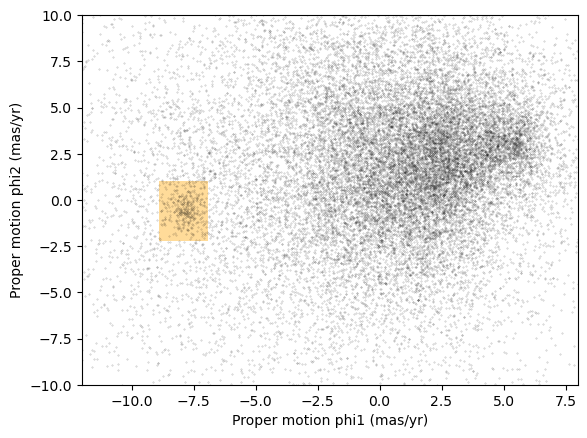

In [172]:
# Add to proper motion plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plot_proper_motion(centerline_df)
poly = Polygon(vertices, closed=True, facecolor='orange', alpha=0.4)

ax.add_patch(poly)

Exercise: add a few lines to be run after plot_cmd to show the polygon we selected as a shaded area. Hint: pass `loop_df` as an argument to Polygon as we did in episode 7 and then plot it using `add_patch`

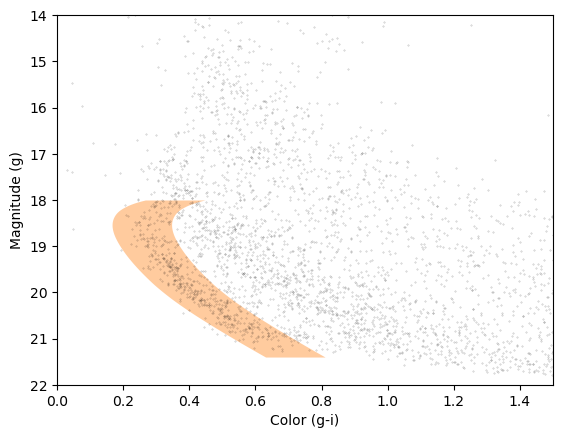

In [176]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plot_cmd(candidate_df)
poly_cmd = Polygon(loop_df, closed=True, facecolor='C1', alpha=0.4)
ax.add_patch(poly_cmd)

Exercise: add the Polygon to your lower right panel of Fig 1

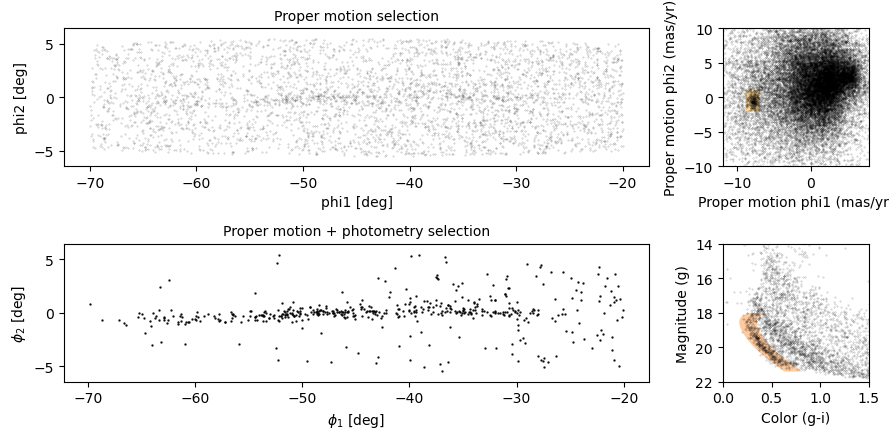

In [179]:
plt.style.use('default')

fig = plt.figure(figsize=(9, 4.5))
shape=(2,4) #Update this
ax1 = plt.subplot2grid(shape, (0,0), colspan=3) 
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0,3))
plot_proper_motion(centerline_df)
poly = Polygon(vertices, closed=True, facecolor='orange', alpha=0.4) #add this
ax2.add_patch(poly) #add this

ax3 = plt.subplot2grid(shape, (1,0), colspan=3) 
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1,3)) 
plot_cmd(candidate_df)
poly_cmd = Polygon(loop_df, closed=True, facecolor='C1', alpha=0.4) #add this
ax4.add_patch(poly_cmd) #add this

plt.tight_layout();